In [1]:

import numpy as np
from numpy import vectorize
from scipy import interpolate, integrate
from scipy import special
from scipy.interpolate import UnivariateSpline, InterpolatedUnivariateSpline, interp1d
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('default')
import timeit

def concentration(Mvir, cosmo_h):
    '''Maccio 07 - Eq. 8. I also found that it is only within 1e9 < M < 5e13.
       What is this Delta_vir=98 in page 57
    '''
    Mvir = Mvir / cosmo_h
    conc = 10**(1.02 - 0.109 * (np.log10(Mvir) - 12.))
    return conc

def f_Rfrac(Rfrac, rho_s, Rs, rho_critical, frac):
    return (frac * rho_critical * Rfrac**3. / 3.) - (rho_s * Rs**3) * (np.log((Rs + Rfrac) / Rs) - Rfrac / (Rs + Rfrac))

def df_Rfrac(Rfrac, rho_s, Rs, rho_critical, frac):
    return (frac * rho_critical * Rfrac**2.) - (rho_s * Rs**3) * (Rfrac / (Rs + Rfrac)**2.)

def MvirToMRfrac(Mvir, BryanDelta, rho_critical, cosmo_h):
    '''Convert Mvir in solar mass to Rvir in Mpc, M200 in solar mass 
       R200 in Mpc
    '''
    conc = concentration(Mvir, cosmo_h)
    #print Mvir, conc
    Rvir = (Mvir / ((4 * np.pi / 3.) * BryanDelta * rho_critical))**(1/3.) #(Msun / Msun Mpc^(-3))1/3. -> Mpc    
    rho_s = rho_critical * (BryanDelta / 3.) * conc**3. / (np.log(1 + conc) - conc / (1 + conc)) #Msun / Mpc^3  
    Rs = Rvir / conc

    tolerance = 1e-6
    frac = 200.0

    # Using Newton - Raphson method. x1 = x0 - f(x0) / f'(x0) where x0 is
    # the initial guess, f and f' are the function and derivative

    # Intial guess is Rvir / 2. 
    x0 = Rvir / 2.0
    tol = Rvir * tolerance #tolerance
    x1 = tol * 10**6
    #print 1, x0, x1
    while abs(x0 - x1) > tol:
        #print abs(x0 - x1), tol
        x0 = x1 * 1.0
        x1 = x0 - f_Rfrac(x0, rho_s, Rs, rho_critical, frac) / df_Rfrac(x0, rho_s, Rs, rho_critical, frac)
        #print x0, x1
    Rfrac = x1
    Mfrac = (4. / 3.) * np.pi * Rfrac**3 * frac * rho_critical
    #print Mvir, Mfrac, Rvir, Rfrac
    return Mfrac, Rfrac 

def battaglia_profile(r, Mvir, z, BryanDelta, rho_critical, omega_b0, omega_m0, cosmo_h):
    '''
    Using Battaglia et al (2012). 
    Eq. 10. M200 in solar mass and R200 in Mpc
    Retrun: 
        Pressure profile in keV/cm^3 at radius r
    '''
    M200, R200 = MvirToMRfrac(Mvir, BryanDelta, rho_critical, cosmo_h)
    #It seems R200 is in the physical distance, i.e. proper distance
    #Need to multiplied by (1+z) to get the comoving unit as I am giving r in
    #comoving unit.
    R200 *= (1. + z) #Comoving radius 
    x = r / R200
    #print Mvir, M200, R200
    msolar = 1.9889e30 #kg
    mpc2cm = 3.0856e24 #cm 
    G = 4.3e-9 #Mpc Mo^-1 (km/s)^2 
    alpha = 1.0
    gamma = -0.3
    P200 = 200. * rho_critical * omega_b0 * G * M200 / omega_m0 / 2. / (R200 / (1. + z)) #Msun km^2 / Mpc^3 / s^2

    P0 = 18.1 * ((M200 / 1e14)**0.154 * (1. + z)**-0.758)
    xc = 0.497 * ((M200 / 1e14)**-0.00865 * (1. + z)**0.731)
    beta = 4.35 * ((M200 / 1e14)**0.0393 * (1. + z)**0.415) 
    #print Mvir,z,R200,P200,P0, xc, beta
    #print (P200*msolar * 6.24e18 * 1e3 / mpc2cm**3), P0, xc, beta
    pth = P200 * P0 * (x / xc)**gamma * (1. + (x/xc))**(-1. * beta) #(km/s)^2 M_sun / Mpc^3

    #Joule = kg m^2 / s^2, Joule = 6.24e18 eV = 6.24e15 keV
    pth *= (msolar * 6.24e15 * 1e6 / mpc2cm**3) #keV/cm^3. 1e6 implies that I have converted km to m
    p_e = pth * 0.518 #For Y=0.24, Vikram, Lidz & Jain
    return p_e

def project_profile(radius, profile) :
        if np.nonzero(profile <= 0)[0].size > 0 : raise Exception("negative profile")
        max_radius = 15
        profile_spline = interp1d(radius, profile, bounds_error=False, fill_value="extrapolate")
        dr = 0.001
        rmin = 0.
        space = int(1 + (max_radius - rmin) / dr)
        sqxi = np.linspace(rmin, max_radius, space)**2.
        profile_projected = []
        for r in radius:
            R = np.sqrt(r**2. + sqxi)
            R = R[R < max_radius]
            profile_projected.append(profile_spline(R).sum()*dr)
        profile_projected = np.array(profile_projected)
        new_radius = radius 
        return new_radius, profile_projected

def make_proj_image(radius, profile) :
        maxRadius = 15
        pixel_scale = 0.15
        image_size = np.round(maxRadius*2/pixel_scale)
        #profile_spline = interp1d(radius, profile, bounds_error=False, fill_value="extrapolate")
        profile_spline = interp1d(radius, profile, bounds_error=False)
        image = np.zeros((np.int_((image_size/2)+1),np.int_(image_size/2)+1))
        rcen, ccen = 0,0
        for r in range(0,np.shape(image)[0]) :
            for c in range(0,np.shape(image)[1]) :
                radius = np.sqrt((r-rcen)**2+(c-ccen)**2) * pixel_scale
                if radius == 0. : radius = 0.1 * pixel_scale
                image[r][c] = profile_spline(radius)
        return image

def make_proj_image_new(radius, profile,maxRadius=15,pixel_scale=0.15,extrapolate=False):
        # You use this quantity as matrix size.
        # I doubt that system dependent np.int32 or np.int64 will have different behaviour
        image_size = np.int_(np.round(maxRadius*2/pixel_scale)/2+1)

        if extrapolate:
            profile_spline = interp1d(radius, profile, kind = 3, bounds_error=False, fill_value="extrapolate")
        else:
            profile_spline = interp1d(radius, profile, bounds_error=False)

        # x and y indices matrices
        x,y=np.meshgrid(np.arange(image_size),np.arange(image_size))
        # matrix of radii with center in x=0,y=0
        r = np.sqrt(x**2+y**2)*pixel_scale
        # numpy and scipy usually maps functions over matrices
        image = profile_spline(r)
        return image

In [2]:
#Variable inputs
Mass = 1e14
redshift = 0.1

a = 1.0/(1.0 + redshift)
E0 = 0.73 + 0.27/(a*a*a) + 0./(a*a)
x = 0.27 - 1
BryanDelta = 18 * np.pi * np.pi + 82. * x - 39. * x * x
rho_crit = 1.879/(1.989)*3.086**3*1e10 * E0
rho_critical = rho_crit * 0.7 * 0.7
omega_b0 = 0.044
omega_m0 = 0.27
cosmo_h = 0.7
radius = np.linspace(0.1, 10, 1000)

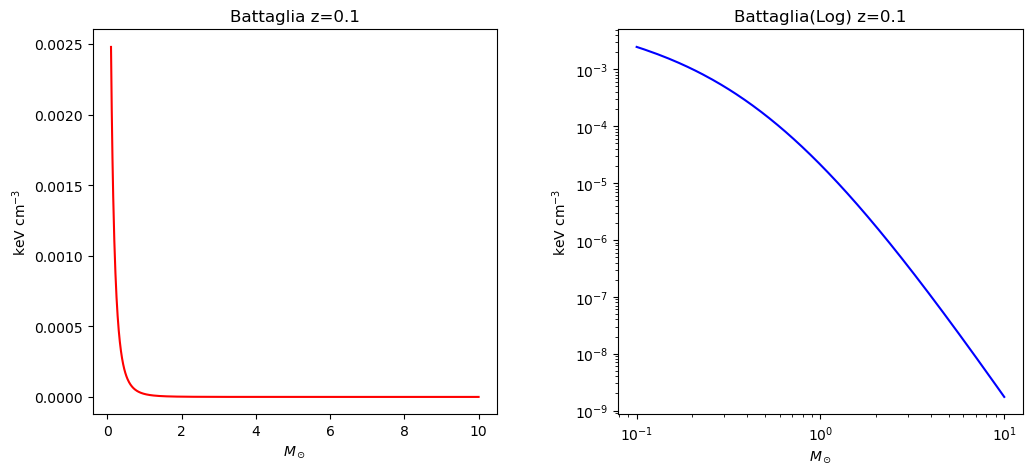

In [3]:
battaglia_pro = np.array([battaglia_profile(r, Mass, redshift, BryanDelta, rho_critical, omega_b0, omega_m0, cosmo_h) for r in np.linspace(0.1, 10, 1000)])
fig,ax = plt.subplots(1,2,figsize = (12,5))
plt.subplots_adjust(wspace = 0.3)
ax[0].plot(radius, battaglia_pro, color = "red", label = "non-log")
ax[0].set_xlabel(r'$M_\odot$')
ax[0].set_ylabel(r'keV cm$^{-3}$')
ax[0].title.set_text("Battaglia z="+str(redshift))
ax[1].loglog(radius, battaglia_pro, color = "blue", label = "log")
ax[1].set_xlabel(r'$M_\odot$')
ax[1].set_ylabel(r'keV cm$^{-3}$')
ax[1].title.set_text("Battaglia(Log) z="+str(redshift))
plt.show()
y_pro = battaglia_pro * 1.615356e15 #converting from pressure profile to y profile

# Old behaviour

Text(0.5, 0, 'Radius')

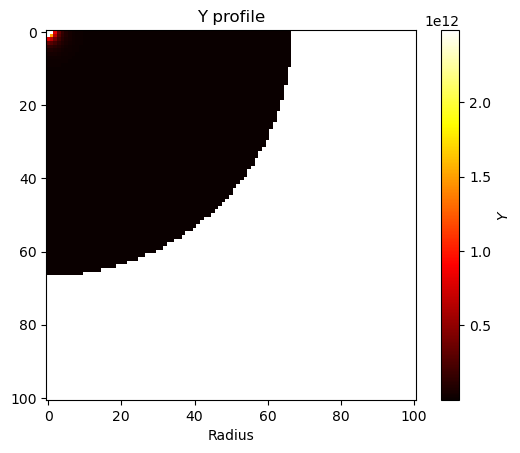

In [4]:
image = make_proj_image(radius,y_pro)
plt.imshow(image, cmap='hot')
cbar = plt.colorbar()
cbar.ax.set_ylabel(r'$Y$')
plt.title('Y profile')
plt.xlabel('Radius')

Text(0.5, 0, 'Radius')

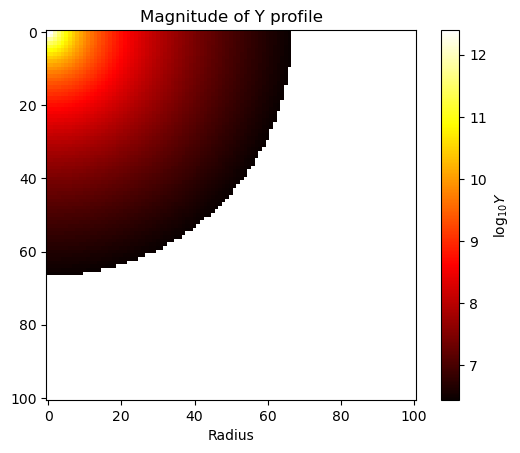

In [5]:
plt.imshow(np.log10(image), cmap='hot')
cbar = plt.colorbar()
cbar.ax.set_ylabel(r'$\log_{10}Y$')
plt.title('Magnitude of Y profile')
plt.xlabel('Radius')

# New bahaviour

In [6]:
image_new = make_proj_image_new(radius,y_pro,extrapolate=False)

In [7]:
print('Output is the same:',(image[~np.isnan(image)]==image_new[~np.isnan(image)]).all())

Output is the same: True


# Suggestion on extrapolation

You actually can use extrapolation here to get a sensible result. But keep in mind that spline uses low power polynomials, so it will fail to properly describe powerlaw. However, your in log scale your powerlaw is a line, so spline extrapolation will handle the line perfectly.

## Wrong extrapolation

Red is positive, white - 0, blue is negative. Spectral energy can not be negative, so this extrapolation is wrong

Text(0.5, 0, 'Radius')

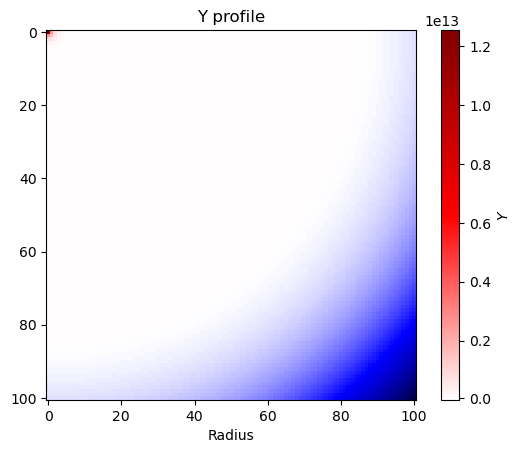

In [8]:
image = make_proj_image_new(radius,y_pro,extrapolate=True)
plt.imshow(image, cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
cbar = plt.colorbar()
cbar.ax.set_ylabel(r'$Y$')
plt.title('Y profile')
plt.xlabel('Radius')

In [9]:
print(image.min())

-75812720.9375


## Correct extrapolation

Extrapolate log(Y), since this is a line

Text(0.5, 0, 'Radius')

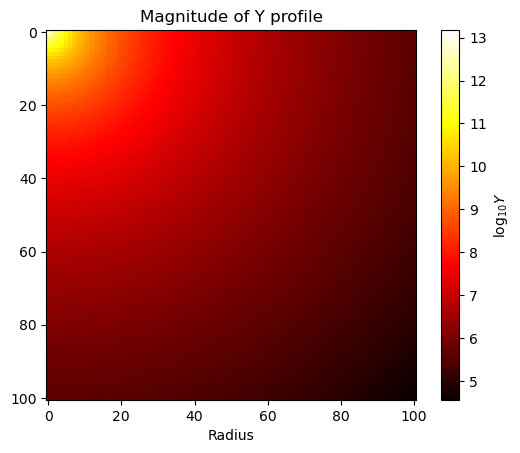

In [10]:
log_image = make_proj_image_new(radius,np.log10(y_pro),extrapolate=True)
plt.imshow(log_image, cmap='hot')
cbar = plt.colorbar()
cbar.ax.set_ylabel(r'$\log_{10}Y$')
plt.title('Magnitude of Y profile')
plt.xlabel('Radius')

In [11]:
print(log_image.max())


13.176539113855824


Now you have sensible results outside of the investigated region. But mind that from some point the spectrum gets flat due to the noise.


# Noise

## White Noise

In [12]:
noise_level = 1e6
noise = np.random.normal(0, 1, (101,101)) * noise_level

In [13]:
rescaled_img = 10**log_image
new_img = rescaled_img + noise
sub = new_img[50:, 50:]
new_img = np.log10(np.where(new_img>1, new_img, 0.1))

Graph log-scaled noise and Y-profile

Text(0.5, 0, 'Radius')

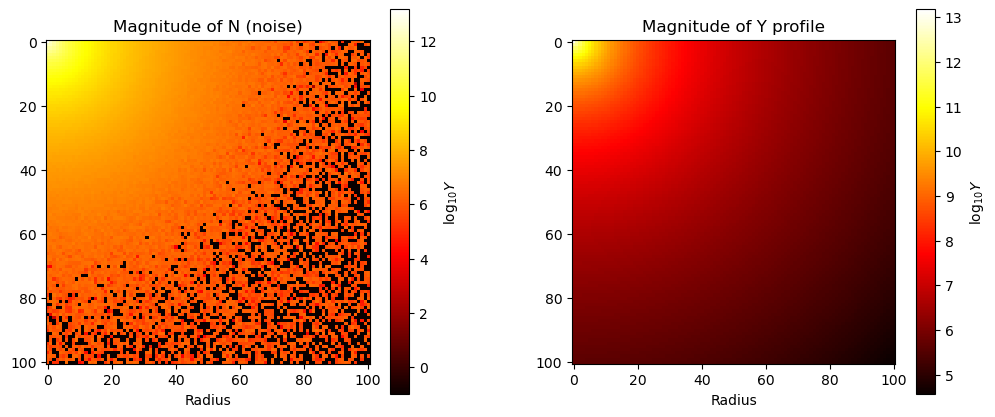

In [14]:
f, axarr = plt.subplots(1, 2, figsize = (12,5))
plt.subplots_adjust(wspace = 0.3)
p1 = axarr[0].imshow(new_img, cmap='hot')
bar1 = f.colorbar(p1, ax = axarr[0])
bar1.ax.set_ylabel(r'$\log_{10}Y$')
axarr[0].title.set_text('Magnitude of N (noise)')
axarr[0].set_xlabel('Radius')
p2 = axarr[1].imshow(log_image, cmap='hot')
bar2 = f.colorbar(p2, ax = axarr[1])
bar2.ax.set_ylabel(r'$\log_{10}Y$')
axarr[1].title.set_text('Magnitude of Y profile')
axarr[1].set_xlabel('Radius')

Text(0.5, 0, 'Radius')

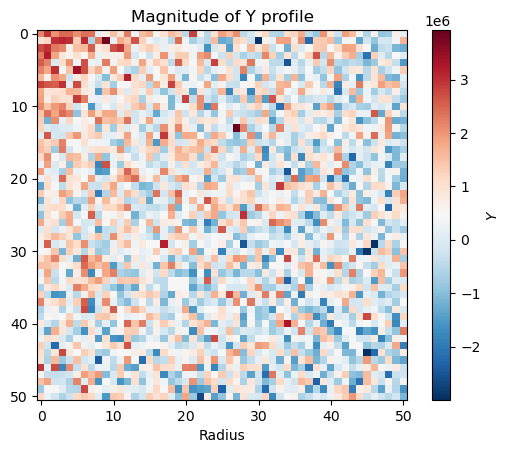

In [15]:
plt.imshow(sub, cmap='RdBu_r')
cbar = plt.colorbar()
cbar.ax.set_ylabel(r'$Y$')
plt.title('Magnitude of Y profile')
plt.xlabel('Radius')

In [16]:
print(sub)

[[ 2167128.82741563  2974891.42140587  2014519.74238965 ...
   -813243.97676784   705431.21967171   120511.77653029]
 [  995238.01519341  1206101.80714234  3005209.58425401 ...
   -201854.35258109   380862.85626181  1645675.68125688]
 [ 2743510.33913365  2985967.79409565  2295324.33925334 ...
   -282229.33970516 -1126842.11710937 -1256213.02606898]
 ...
 [ 1476001.94592692  1847733.16022566  -261925.14758643 ...
    564351.35646181  -532526.02358059   325092.17790278]
 [ -783003.22122795   408432.12263693   545620.75279177 ...
    203116.96872024  -539038.11564904 -1581847.99602447]
 [ 1162194.06711888   263795.02767253  -201786.47852603 ...
   -474579.32161785  -172197.23967638 -1104226.28283762]]
